# PyTorch Notes

## Contents
**1. Quickstart Guide**<br>
 - Quick implementation of a simple neural net.
 - Basic understanding of capabilites of PyTorch.


**2. Introduction to PyTorch**<br>
 - Introduction to tensors, methods, forward and backward passes.


**3. Overview of PyTorch Autograd Engine**<br>
 - High-level explaination of auto-grad process - computational graph and gradients.


**4. How computational graphs are constructed in PyTorch**<br>
 - Reading list for under the hood python and C++ objects for working with computational graphs and autograd


**5. Understanding Computational Graphs**<br>
 - Some additional information about computational graphs
 
**6. Understanding Autograd: 5 Pytorch tensor functions**<br>
 - Most important 5 functions related to tensors

**7. Miscellaneous Info**


## 1. Quickstart Guide

Reference: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [2]:
import torch 
from torch import nn # all neural nets inherit the nn module for basic functionality
from torch.utils.data import DataLoader # pytorch basic module for data is DataSet. Dataloader is a iterable over dataset, for auto-batching
from torchvision import datasets # torchvision contains datasets for vision problems
from torchvision.transforms import ToTensor # a function to convert vision problem data into tensors

### Dataset/loader

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
# from datasets - fashion dataset is queried
# we take only training part by making train = True
# downlaod and save it in true all while transforming into tensors (no scaling recentering done yet)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False, #this gets you non-training data
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14047816.35it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 216360.32it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4441916.55it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5689664.56it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size) 
test_dataloader = DataLoader(test_data, batch_size=batch_size)
# again, dataloaders are iterables over A Dataset. 
# Not a iterable of datasets.
# They allow auto-batching and separte inpute and outputs just like datasets


for X, y in test_dataloader: # dataloader is an iterable but not indexable
    print(f"Shape of X [N, C, H, W]: {X.shape}") # C stands for channel. Always a standard in image data
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" # didnt know python allows multple single line 'if elses'
    if torch.cuda.is_available()
    else "mps" # Multi-Process Service - Cuda alternative
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module): # inherits nn
    def __init__(self): 
        super().__init__() # inherites the init of nn
        self.flatten = nn.Flatten() #making flatten a object funciton doesnt actually do much
        # but nn.flatten unlike torch.flatten flattens AFTER the first dim ('start_dim')
        # the first dimension is usually batch dim, which we dont want to flatten
        # 5 x 3 x 3 x 1 --> 5 batches of 3x3x1 data. Flatten only the 3x3x1 part
        
        
        self.linear_relu_stack = nn.Sequential(#defining model
            nn.Linear(28*28, 512),#by default all params are requires_grad=True
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)# we are using nn.flatten, probably could use nn.flattend directly here without affecting anything
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device) # model is in device. First thing in device
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()#loss function here is an instantiation of cross entropy loss


optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# unlike loss optimizer needs to know about your model to be defined
# why?
# optimizer needs to know all the params it is going to update. 
# it looks at the model and considers each weight with requires_grad = True
# each tensor with requiresgrad in pytorch has a grad associated in its definition
# optimizer goes and updates this grad

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset) # Total size of dataset being used
    model.train() # When a model is being trained it behaves diffrenetly than when it is being evaluated
    # how? Most importantly gradients not being updated
    # Another, dropout for example. gradient updates etc are all turned on for training mode
    # remember your train() should be wrapped insde a funciton so its called only when u are actually training
    
    for batch, (X, y) in enumerate(dataloader): #dataloader separates X,y when iterating over it
        X, y = X.to(device), y.to(device) 
        # imp. if model is on a device, data must be on same device to train or evaluate.
        # Only save to device if being used. Dont save anything unnecessary

        
        pred = model(X) # equivalent to model.forward(X)
        loss = loss_fn(pred, y)
        # Things that are happening -->
        # 
        
        
        
        # Backpropagation <VERY IMPORTANT>
        loss.backward() 
        # backward is a property of tensor
        # what does backward do? #accumulation of gradients
        
        
        optimizer.step() 
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306728  [   64/60000]
loss: 2.287720  [ 6464/60000]
loss: 2.278190  [12864/60000]
loss: 2.266025  [19264/60000]
loss: 2.251162  [25664/60000]
loss: 2.221402  [32064/60000]
loss: 2.230715  [38464/60000]
loss: 2.195994  [44864/60000]
loss: 2.202322  [51264/60000]
loss: 2.155398  [57664/60000]
Test Error: 
 Accuracy: 36.8%, Avg loss: 2.156737 

Epoch 2
-------------------------------
loss: 2.170611  [   64/60000]
loss: 2.153255  [ 6464/60000]
loss: 2.100664  [12864/60000]
loss: 2.111635  [19264/60000]
loss: 2.067943  [25664/60000]
loss: 2.005867  [32064/60000]
loss: 2.044993  [38464/60000]
loss: 1.963157  [44864/60000]
loss: 1.974150  [51264/60000]
loss: 1.895306  [57664/60000]
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.893672 

Epoch 3
-------------------------------
loss: 1.927311  [   64/60000]
loss: 1.888460  [ 6464/60000]
loss: 1.778417  [12864/60000]
loss: 1.814532  [19264/60000]
loss: 1.716070  [25664/60000]
loss: 1.668375  [32064/600

### Saving and loading Models

In [10]:
# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))

### Evaluation

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## 2. Introduction to PyTorch

Reference: https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html#creating-tensors

### Tensors

Stores numbers, does stuff

In [12]:
# torch.tensor(data) creates a torch.Tensor object with the given data.
V_data = [1., 2., 3.]
V = torch.tensor(V_data)
# print(V)

# Creates a matrix
M_data = [[1., 2., 3.], [4., 5., 6]]
M = torch.tensor(M_data)
# print(M)

# Create a 3D tensor of size 2x2x2.
T_data = [[[1., 2.], [3., 4.]],
          [[5., 6.], [7., 8.]]]
T = torch.tensor(T_data)
# print(T)

# # Index into V and get a scalar (0 dimensional tensor)
# print(V[0])
# # Get a Python number from it
# print(V[0].item()) #ONLY APPLICABLE IF SLICE IS SCALAR

# # Index into M and get a vector
# print(M[0])

# # Index into T and get a matrix
# print(T[0])

**Common Methods**

In [13]:
## indexing
# # Index into V and get a scalar (0 dimensional tensor)
# print(V[0])
# # Get a Python number from it
# print(V[0].item()) #ONLY APPLICABLE IF SLICE IS SCALAR

# # Index into M and get a vector
# print(M[0])

# # Index into T and get a matrix
# print(T[0])

#concatenation
# By default, it concatenates along the first axis (concatenates rows)
x_1 = torch.randn(2, 5)
y_1 = torch.randn(3, 5)
z_1 = torch.cat([x_1, y_1]) # row-wise concat
# z_1 = torch.cat([x_1, y_1], 1) #concatenates columns, wont work this case

#reshaping = viewing
x = torch.randn(2, 3, 4)
# print(x)
# print(x.view(2, 12))  # Reshape to 2 rows, 12 columns
# # Same as above.  If one of the dimensions is -1, its size can be inferred
# print(x.view(2, -1))

**Computation Graphs and Automatic Differentiation** 

1. Consider numpy arrays. They do everything we discussed so far. We can index, reshape, concatenate and do math functions over them.
2. But tensors are for ML use, where differentiation like d(tensor)/d(some other tensor) is an expected  requirement.
3. This can be done numerically but that is slow and inaccurate.
4. But to do them analytically we need to know how tensors are related to each other. eg. tensor = some tensor - third tensor
5. To do this we need to know how 'tensor' is related to 'some other tensor'.
6. Tensors have a `.requires_grad` prop, which when true, pytorch will keep track of that tensors creation and relations to others using a graph.

In [14]:
# Tensor factory methods have a ``requires_grad`` flag
x = torch.tensor([1., 2., 3], requires_grad=True)

# With requires_grad=True, you can still do all the operations you previously
# could
y = torch.tensor([4., 5., 6], requires_grad=True)
z = x + y
print(z)

# BUT z knows something extra.
print(z.grad_fn) # it kept track of the operation that generated it!


tensor([5., 7., 9.], grad_fn=<AddBackward0>)


In [16]:
#but
x = torch.tensor([1., 2., 3], requires_grad=False)
y = torch.tensor([4., 5., 6], requires_grad=False)
z = x + y #forward operation, graph will be creaeted now
# z.requires_grad = True #does not help, as forward operation already done
print(z)

# BUT z doesnt know know something extra now.
print(z.grad_fn) #Did  it track of the operation that generated it?


tensor([5., 7., 9.])
None


**Consider following:**

x,y --add--> z --sum-->s

1. we know 's' knows how it was made from z, and thus how (how? by recursively traversing the graph) it was made from the terminating leaves - x and y.
2. how can we find ds/dx or ds/dy with this knowledge?
3. pytorchs autograd engine knows how to calculate partial derivatives from the roots to the nodes from these graphs. <br>
eg. x,y --add--> z. Sooo <br>
dz/dx = y and dz/dy = x

**Computation graph creation --> during forward pass (not a explicit method)**

**Gradient calculation --> backward pass (a explicit method)**

In [153]:
x = torch.tensor([1., 2., 3], requires_grad=True)
y = torch.tensor([4., 5., 6], requires_grad=True)
z = x + y
s = z.sum()
s.backward()# calling .backward() on any variable will run backprop, starting from it.
print(x.grad) #[ds/dx1(x1), ds/dx2(x2), ds/dx3(x3)]

tensor([1., 1., 1.])


In [154]:
#ORRR
x = torch.tensor([1., 2., 3], requires_grad=True)
y = torch.tensor([4., 5., 6], requires_grad=True)
z = x**2 + y
# z = x**3 + y
# z = torch.sin(x) + y
s = z.sum()
s.backward()# calling .backward() on any variable will run backprop, starting from it.
print(x.grad) #[ds/dx1(x1), ds/dx2(x2), ds/dx3(x3)]

tensor([2., 4., 6.])


In [155]:
x = torch.randn(2, 2)
y = torch.randn(2, 2)
# By default, user created Tensors have ``requires_grad=False``
print(x.requires_grad, y.requires_grad)
z = x + y
# So you can't backprop through z
print(z.grad_fn)

# ``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
# flag in-place. The input flag defaults to ``True`` if not given.
x = x.requires_grad_()
y = y.requires_grad_()

#this works too but is avoided in good code, idk y
# x.requires_grad = True 
# y.requires_grad = True
# z contains enough information to compute gradients, as we saw above
z = x + y
print(z.grad_fn)


# IMPORTANT
# If ANYYY input to an operation has ``requires_grad=True``, so will the output
print(z.requires_grad)

False False
None
True


**DETACH** 

In [156]:
# Now z has the computation history that relates itself to x and y
# Can we just take its values, and **detach** it from its history?
new_z = z.detach()

# ... does new_z have information to backprop to x and y?
# NO!
print(new_z.grad_fn)
# And how could it? ``z.detach()`` returns a tensor that shares the same storage
# as ``z``, but with the computation history forgotten. It doesn't know anything
# about how it was computed.
# In essence, we have broken the Tensor away from its past history

None


**NOGRAD**

In [157]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad) # does NOT actually change the requires_grad of x
    y = x**2 #anything defined here does not have required_grad, why? because x does not have req_grad true here

print(y.requires_grad)

True
True
False
False


# 3. Overview of PyTorch Autograd Engine

https://pytorch.org/blog/overview-of-pytorch-autograd-engine/

1. In previous chapter we understood, why. here we go over basics of how autograd actually works with the computational graph
2. btw this process of making a graph in forward pass and only generating gradients of each var in reverse pass is called reverse-mode autograd
3. Fundamental core idea of autograd --> Chain rule and recursion

Consider the function:

f(x,y) = log(x.y)

Broken down into a forward graph as

**Tensors:** `x,y` --`mult`-->`v` --`log`-->`w`

`w` is the root node. So every `t` with `.requires_grad=True` in the graph of `w` will have its `.grad` accumulated with `dw/dx` if we call `w.backward()`


The backward graph looks like:

**Grads:** `dw/dx, dw/dy` <-- `mult derv` -- `dw/dv` <--`log derv`--`dw/dw=1`


**Note:** In the picture below z is a dummy variable that allows storage of 1 as the gradient of the root node w and the subsequent application of chain rule

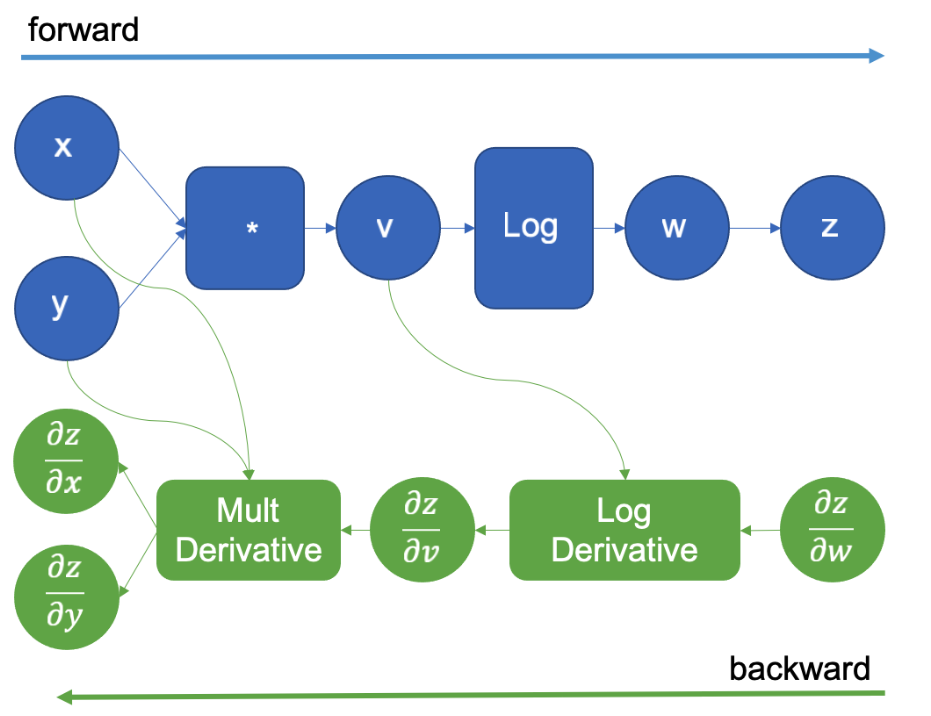

**JVP:** The model actually only calculates the jacobian vector product as the parameters are vectors at each level of the pass. 

Consider `x1,x2` as inputs to function `f--> y1,y2`, which is input to `g-->y`, such that `y=g(f(x1,x2))`.

The `(Jacobian of y wrt x1,x2) = (Jacobian of f wrt x1,x2)^T(Jacobian of
g wrt y1,y2)`


It is important to note that torch does not actually generate the Jacobian but only the Jacobian vector product as it is more efficient.

**NOTE: Link for jvp derivateves --** https://github.com/pytorch/pytorch/blob/master/tools/autograd/derivatives.yaml


For examaple `dz/dv` in the above example is `dlogv/dv = 1/v` and thus `gradient*=1/v` is stored in `v.grad`, in this particular case `gradient=1` before being multiplied.

# 4. How computational graphs are constructed in PyTorch

https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

1. https://github.com/pytorch/pytorch/tree/release/1.9/tools/autograd

2. https://github.com/pytorch/pytorch/tree/release/1.9/torch/autograd

3. https://github.com/pytorch/pytorch/tree/release/1.9/torch/csrc/autograd

above are three main modules that deal with graphs and autograd. 1. is for the base level functions, 2. allows users to write their own diff functions and compute jvps and 3. is for graph related objects

# 5. Understanding Computational Graphs

https://jdhao.github.io/2017/11/12/pytorch-computation-graph/


The fundamental object of PyTorch is the computational graph. The computational graph is generated during any torch operation over torch object, Tensor. 

In the backward pass the graph is used to calculate gradients for the tensors in the direction of the root node quantity.

It is IMPORTANT to note that, in a usual neural net paradigm, where forward and backward passes occur in each iteration. **The graph is created (forward) and destroyed (backward) in each iteration unless specified otherwise**.

Consider the operations:


`a`--`polynomial`-->`b`--`mult`-->`c`--`mean,sum`-->`d`,`e`

In [158]:
from torch.autograd import Variable
a = Variable(torch.rand(1, 4), requires_grad=True) #variable is a object around tensor, w all tensor properties used usually for non-constant/variables
b = a**2
c = b*2
d = c.mean()
e = c.sum()

Now we lets do backward on both d and e

In [159]:
# d.backward()
# e.backward()
# you will get this error
print('RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.')

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


A real use case that you want to backward through the graph for more than once is multi-task learning where you have multiple losses at different layers. Suppose that you have 2 losses: `loss1` and `loss2` and they reside in different layers. In order to back-prop the gradient of `loss1` and `loss2` w.r.t to the learnable weight of your network independently. You have to use `retain_graph=True` in `backward()` method in the first back-propagated loss.

In [160]:
d.backward(retain_graph=True)
e.backward(retain_graph=True) 

# 6. Understanding Autograd: 5 Pytorch tensor functions

https://medium.com/@namanphy/understanding-autograd-5-pytorch-tensor-functions-8f47c27dc38

Computation graph is nothing but a simple map of references of variables(or tensors) and operators(or functions) generated for a set of algebraic equations, through which autograd can traverse and trace back (to leaves) to calculate gradients.

**1. Tensor Properties:**
 - `.requires_grad` : if true, the tensor will be tracked during operations related to it. Important to note that IF one of the input tensors has requires_grad as true, the resulting tensor will also automatically have it to be true.
 - `.grad_fn` : Grad function holds reference to the immediate function that created the tensor. Generated during forward pass.
 - `.is_leaf` : (Important), Any tensor with `.requires_grad = False` will have this property as `True`. If `.requires_grad = True` then this property will be `True` if the tensor is user created and not a result of a operation OR more thoroughly if `.grad_fn=None`. **In a neural network context - inputs, weights, biases are leaves.** They are not generated through a process. The specific activations are not leaves. Inputs will usually have requires_grad as `false` and thus grad wont be calculated. Params will have it `true` and thus will be calculated and accumulated.
 
 
Leaf tensors are tensors that stop the flow of gradients on the backward pass. They can store gradients themselves. But they will not allow gradients to flow back through them to other tensors.

In [161]:
#is_leaf examples

a = torch.rand(10, requires_grad=True)
print(a.is_leaf, '- because user generated')

b = torch.rand(10, requires_grad=True).to(device)
print(b.is_leaf, '- because .to(device) is a operation (casting) done on the tensor')

c = torch.rand(10, requires_grad=True) + 2
print(c.is_leaf, '- because an operation is done')

d = torch.rand(10).to(device)
print(d.is_leaf, '- because no gradients, require_grad = False')

e = torch.rand(10).to(device).requires_grad_()
print(e.is_leaf, '- the operation to() was done on a non-grad tensor which then was set to required grad, which is not operation')

f = torch.rand(10, requires_grad=True, device=device)
print(f.is_leaf, '- no operations')

True - because user generated
False - because .to(device) is a operation (casting) done on the tensor
False - because an operation is done
True - because no gradients, require_grad = False
True - the operation to() was done on a non-grad tensor which then was set to required grad, which is not operation
True - no operations


**2. backward():**

- Generates gradient of current tensors w.r.t leaves of its graph.
- `backward(gradient=None, retain_graph=None, create_graph=False)`. Backward takes the incoming gradient in `gradient`, calculates the local gradient, multiplies them and pushes them towards leaves by traversing the graph backwards.

Consider the 

a,x,b --> y = a.x --> z = y + b

In [162]:
x = torch.tensor(3., requires_grad=True)
a = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
y = a * x
z = y + b
z.backward()

print("Tensor x (leaf)")
print(f'grad funtion = {x.grad_fn}')

print("\nTensor a (leaf)")
print(f'grad funtion = {a.grad_fn}')

print("\nTensor b (leaf)")
print(f'grad funtion = {b.grad_fn}')

print("\nTensor y")
print(f'grad funtion = {y.grad_fn}')

print("\nTensor z")
print(f'grad funtion = {z.grad_fn}')
print("\n")
print('dz/dx = a:', x.grad) 
print('dz/da = x:', a.grad) 
print('dz/db = 1:', b.grad) 

Tensor x (leaf)
grad funtion = None

Tensor a (leaf)
grad funtion = None

Tensor b (leaf)
grad funtion = None

Tensor y
grad funtion = <MulBackward0 object at 0x7fcbfbcfd990>

Tensor z
grad funtion = <AddBackward0 object at 0x7fcbfbcfd990>


dz/dx = a: tensor(4.)
dz/da = x: tensor(3.)
dz/db = 1: tensor(1.)


**Calling backward on a non-scaler tensor?**

will get you a `Runtime error: grad can be implicitly created only for scalar outputs` error. This is because the default incoming gradient shape (1) does not match the shape of the shape of whatever tensor you are diffrentiating. 

To work around this pass a gradient of required size to the backward method

In [163]:
x = torch.tensor(3., requires_grad=True)
a = torch.tensor([4.,2.], requires_grad=True)
z = x + a

z.backward(torch.tensor([1.,1.])) # passing a gradient to backward.
#anything other than ones will scale the gradients by appropriate amount

**3. retain_grad()**

Allows a non-leaf node to store gradient that passes through it during backward pass. Used for troubleshooting. Without it you will not be able to `.grad` for non leaf nodes

In [164]:
x = torch.tensor(3., requires_grad=True)
a = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)

y = a * x + b
y.retain_grad()

c = torch.tensor(4., requires_grad=True)
d = torch.tensor(4., requires_grad=True)

w = c * y + d
w.retain_grad() #try commenting out

w.backward()

print('dw/dx:', x.grad) 
print('dw/da:', a.grad) 
print('dw/db:', b.grad) 
print('dw/dy:', y.grad)
print('dw/dc:', c.grad) 
print('dw/dd:', d.grad) 
print('dw/dw:', w.grad)

dw/dx: tensor(16.)
dw/da: tensor(12.)
dw/db: tensor(4.)
dw/dy: tensor(4.)
dw/dc: tensor(17.)
dw/dd: tensor(1.)
dw/dw: tensor(1.)


**4. register_hook()**

`hook(grad) -> Tensor or None`

the hook can take the value of grad and can return a new value or perform operations with the value

In [165]:
# it is useful for playing around with gradients and debugging

v = torch.tensor([0., 0., 0.], requires_grad=True) #any tensor
hook = v.register_hook(lambda grad: grad * 2)  # double the gradient
v.backward(torch.tensor([1., 2., 3.])) #applies hook to grad while passing
print(v.grad)
hook.remove()

tensor([2., 4., 6.])


**5. detach()**

It creates a copy of a tensor that is not a part of the computation graph i.e detaches the Tensor from the graph that created it, making it a leaf.


In [166]:
print(f'Original V : {v}')
new = v.detach()
new[0] = 5
print(f'New detached V : {new}')
print(f'New V : {v}') #still is connected to the original tensor

# it is just a leaf-ed version of ur tensor


Original V : tensor([0., 0., 0.], requires_grad=True)
New detached V : tensor([5., 0., 0.])
New V : tensor([5., 0., 0.], requires_grad=True)


# 7. Miscellaneous

**Application of `retain_graph=True` in adversarial scenario:**<br>
https://stackoverflow.com/questions/62133737/how-does-pytorchs-loss-backward-work-when-retain-graph-true-is-specified

https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method

Why retain_graph is important in scenarios where two networks have a connected graph - because the first pass will clear the graph and make it not possible to pass the gradients through the second loss, without using `retain_graph`.
